<a href="https://colab.research.google.com/github/AugustoBonifacio001/AugustoBonifacio001/blob/main/Compressive_Sensing_para_Estima%C3%A7%C3%A3o_de_Harm%C3%B4nicos_e_Interharm%C3%B4nicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Algoritmo CoSaMP com a dct**


cosamp, dct
Iteração 1/5


/tmp/ipython-input-1489779876.py:110: ComplexWarning: Casting complex values to real discards the imaginary part
  prd_values[i] = calculate_prd(y, reconstructed_clean)
/tmp/ipython-input-1489779876.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  prd_noisy_values[i] = calculate_prd(y, reconstructed_noisy)  # Comparando com o original sem ruído
/tmp/ipython-input-1489779876.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  rmse_values[i] = calculate_rmse(y, reconstructed_clean)
/tmp/ipython-input-1489779876.py:113: ComplexWarning: Casting complex values to real discards the imaginary part
  rmse_noisy_values[i] = calculate_rmse(y, reconstructed_noisy)


Iteração 2/5
Iteração 3/5
Iteração 4/5
Iteração 5/5

Resultados para o sinal SEM ruído na entrada:
PRD médio: 4.71% ± 0.02%
RMSE médio: 0.0356 ± 0.0002

Resultados para o sinal COM ruído (SNR = 20dB):
PRD médio: 3.95% ± 0.00%
RMSE médio: 0.0298 ± 0.0000

Erros médios nas harmônicas (com ruído):
Harmônica 1: 0.0034 ± 0.0140
Harmônica 3: 0.1936 ± 0.0789
Harmônica 7: 0.4924 ± 0.0996
Harmônica 15: 1.5512 ± 0.4838
Harmônica 27: 18.5874 ± 0.3429
Harmônica 35: 30.9284 ± 0.8746
Harmônica 45: 99.9979 ± 0.0010


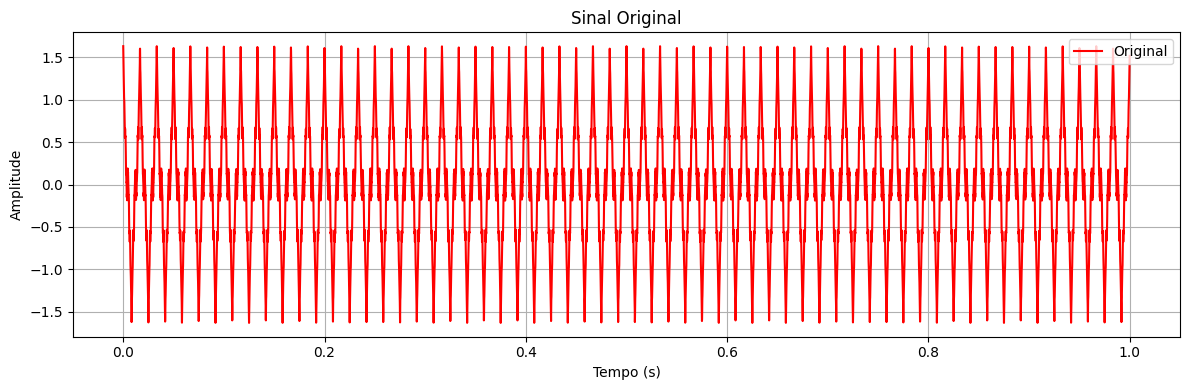

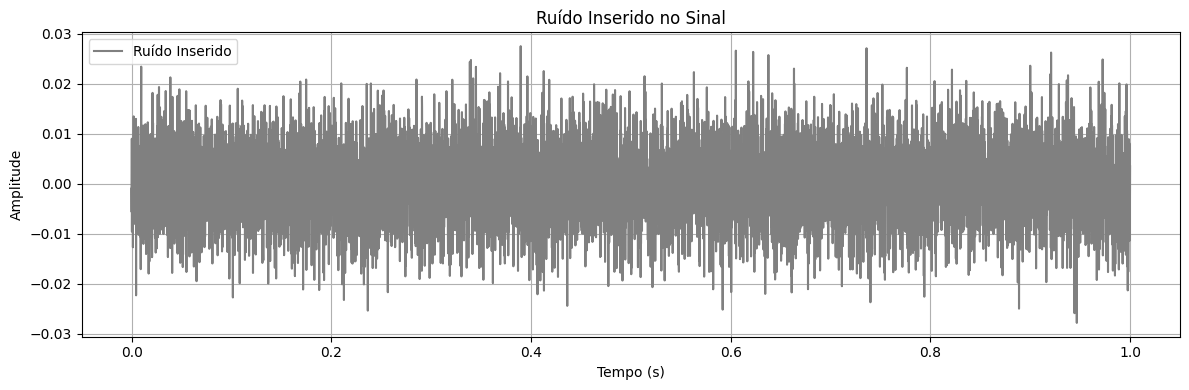

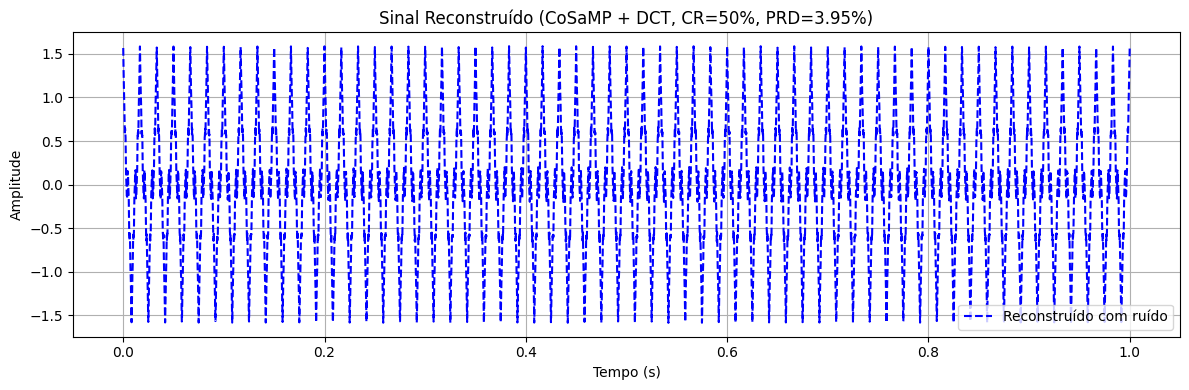

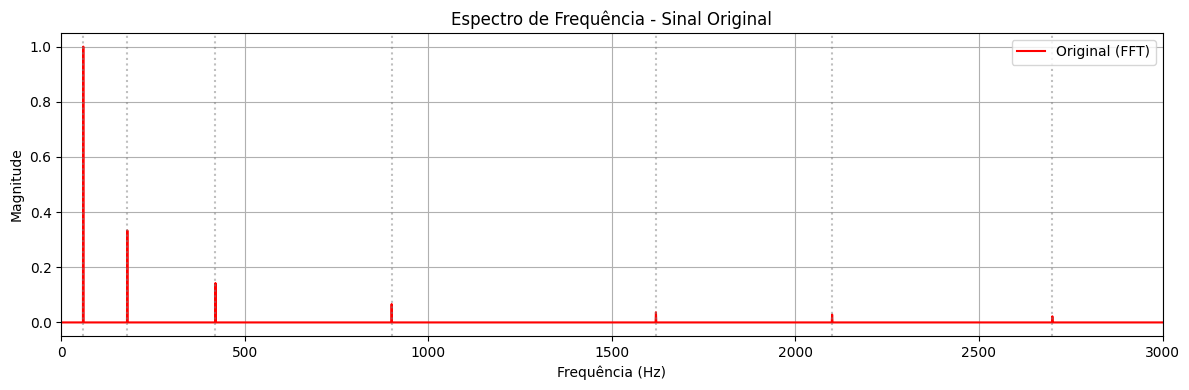

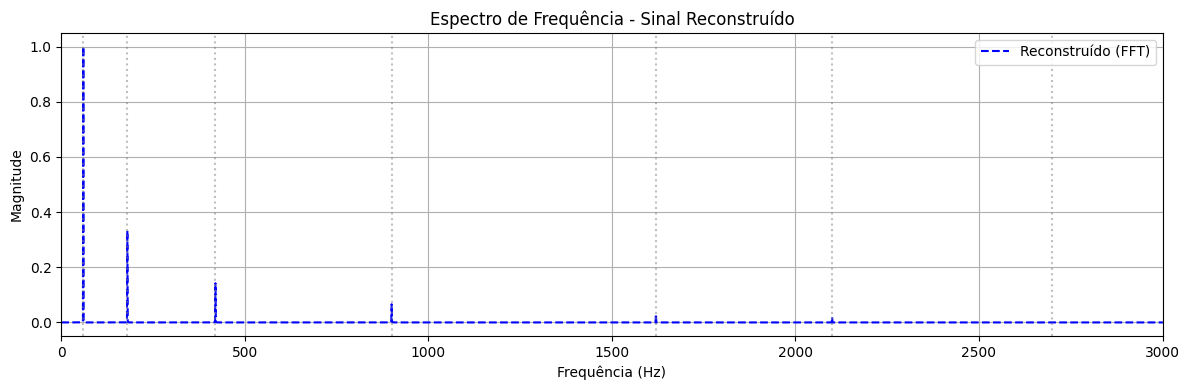

"\n# Espectro de Frequência (FFT)\nfreq = np.fft.fftfreq(N, Ts)[:N//2]\nplt.figure(figsize=(12, 6))\nplt.plot(freq, 2/N * np.abs(np.fft.fft(y)[0:N//2]), label='Original (FFT)')\nplt.plot(freq, 2/N * np.abs(np.fft.fft(y_ruidoso)[0:N//2]), alpha=0.7, label='Ruidoso (FFT)')\nplt.plot(freq, 2/N * np.abs(np.fft.fft(reconstructed_noisy)[0:N//2]), '--', label='Reconstruído (FFT)')\nfor h in harm:\n    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)\nplt.xlim(0, 3000)\nplt.xlabel('Frequência (Hz)')\nplt.ylabel('Magnitude')\nplt.title('Espectro de Frequência')\nplt.legend()\nplt.grid()\nplt.tight_layout()\nplt.show()\n"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
print("cosamp, dct")
# Funções de métrica
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Parâmetros do sinal
Fs = 8192       # Frequência de amostragem
Ts = 1 / Fs     # Período de amostragem
t = np.arange(Fs) * Ts  # Vetor de tempo
f = 60          # Frequência fundamental (Hz)

# Sinal harmônico com componentes ímpares
harm = [1, 3, 7, 15, 27, 35, 45]
y = np.sum([(1/h) * np.cos(2 * np.pi * h * f * t) for h in harm], axis=0)

# sinal original
original_dct = 2*np.abs(np.fft.fft(y, norm='ortho'))/len(y)
#dct(y, norm='ortho')

# Adição de ruído gaussiano
SNR_dB = 40  # Razão sinal-ruído em dB
ruido = np.random.normal(0, np.sqrt(np.var(y)/(10 ** (SNR_dB / 10))), len(y))
y_ruidoso = y + ruido

# Compressive Sensing
CR = 50  # Taxa de compressão (60%)
N = len(y)
M = int(N * (100 - CR) / 100)  # Número de medidas

# Algoritmo CoSaMP verdadeiro
def cosamp(Phi, y, K, max_iter=10, tol=1e-5):
    residual = y.copy()
    idx = np.array([], dtype=int)
    x = np.zeros(Phi.shape[1], dtype=complex)

    for _ in range(max_iter):
        proxy = Phi.conj().T @ residual
        omega = np.argsort(np.abs(proxy))[-2*K:]
        idx = np.union1d(idx, omega).astype(int)
        Phi_selected = Phi[:, idx]
        b, _, _, _ = np.linalg.lstsq(Phi_selected, y, rcond=None)

        # Prune
        idx_new = np.argsort(np.abs(b))[-K:]
        idx = idx[idx_new]
        x_temp = np.zeros(Phi.shape[1], dtype=complex)
        x_temp[idx] = b[idx_new]
        residual = y - Phi @ x_temp

        if np.linalg.norm(residual) < tol:
            break
    return x_temp

"""
# Algoritmo COSAMP (1 iteração por chamada)
def cosamp(A, s, num_coefs=40):

    r = s.copy()
    correlations = np.abs(A.T @ r)
    idx = np.argsort(correlations)[-2*num_coefs:]  # Seleciona 2*num_coefs candidatos
    A_selected = A[:, idx]
    x_selected = np.linalg.lstsq(A_selected, s, rcond=None)[0]

    # Mantém apenas os maiores coeficientes
    idx_top = np.argsort(np.abs(x_selected))[-num_coefs:]
    x = np.zeros(A.shape[1])
    x[idx[idx_top]] = x_selected[idx_top]

    return x
"""
# Execução do experimento (200 iterações)
n_iterations = 5
prd_values = np.zeros(n_iterations)
prd_noisy_values = np.zeros(n_iterations)
rmse_values = np.zeros(n_iterations)
rmse_noisy_values = np.zeros(n_iterations)
harmonic_errors = np.zeros((n_iterations, len(harm)))

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")
    # Amostragem aleatória diferente a cada iteração
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    # Matriz de medição (DCT subamostrada)
    A = dct(np.eye(N), norm='ortho')[samples, :]

    # Medições com e sem ruído
    clean_measurements = y[samples]
    noisy_measurements = y_ruidoso[samples]

    # Reconstrução com COSAMP (1 iteração)
    # Reconstrução do sinal limpo (para comparação)
    coeffs_clean = cosamp(A, clean_measurements, K=14)
    reconstructed_clean = idct(coeffs_clean, norm='ortho')
    reconstructed_clean = reconstructed_clean * (np.max(y) / np.max(reconstructed_clean))

    # Reconstrução do sinal ruidoso
    coeffs_noisy = cosamp(A, noisy_measurements, K=14)
    reconstructed_noisy = idct(coeffs_noisy, norm='ortho')
    #reconstructed_noisy = reconstructed_noisy #* (np.max(y_ruidoso) / np.max(reconstructed_noisy))

    # Cálculo das métricas
    prd_values[i] = calculate_prd(y, reconstructed_clean)
    prd_noisy_values[i] = calculate_prd(y, reconstructed_noisy)  # Comparando com o original sem ruído
    rmse_values[i] = calculate_rmse(y, reconstructed_clean)
    rmse_noisy_values[i] = calculate_rmse(y, reconstructed_noisy)

    # Erros nas harmônicas (usando a reconstrução ruidosa)
    recon_dct = 2*np.abs(np.fft.fft(reconstructed_noisy, norm='ortho'))/len(reconstructed_noisy)
    #for j, h in enumerate(harm):
    for j in range(len(harm)):
        #idx_h = int(h * f * N / Fs)
        idx_h = (int(harm[j]) * f/(Fs/N))
        #idx_h = (idx_h).astype(int)
        harmonic_errors[i, j] = 100*(np.abs(original_dct[(int(idx_h))]) - np.abs(recon_dct[(int(idx_h))]))/np.abs(original_dct[(int(idx_h))])

# Resultados finais
print("\nResultados para o sinal SEM ruído na entrada:")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")

print("\nResultados para o sinal COM ruído (SNR = 20dB):")
print(f"PRD médio: {np.mean(prd_noisy_values):.2f}% ± {np.std(prd_noisy_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_noisy_values):.4f} ± {np.std(rmse_noisy_values):.4f}")
print("\nErros médios nas harmônicas (com ruído):")
for j, h in enumerate(harm):
    print(f"Harmônica {h}: {np.mean(harmonic_errors[:, j]):.4f} ± {np.std(harmonic_errors[:, j]):.4f}")

# Plot dos sinais

# Sinal de ruído inserido
ruido_inserido = y_ruidoso - y

# Plot do sinal original
plt.figure(figsize=(12, 4))
plt.plot(t, y, label='Original', color='red')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Original')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Plot do ruído inserido
plt.figure(figsize=(12, 4))
plt.plot(t, ruido_inserido, label='Ruído Inserido', color='gray')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Ruído Inserido no Sinal')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Plot do sinal reconstruído
plt.figure(figsize=(12, 4))
plt.plot(t, reconstructed_noisy, label='Reconstruído com ruído', linestyle='--', color='blue')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title(f'Sinal Reconstruído (CoSaMP + DCT, CR={CR}%, PRD={np.mean(prd_noisy_values):.2f}%)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Espectro de Frequência (FFT) - Original
freq = np.fft.fftfreq(N, Ts)[:N//2]
fft_y = 2/N * np.abs(np.fft.fft(y)[0:N//2])

plt.figure(figsize=(12, 4))
plt.plot(freq, fft_y, label='Original (FFT)', color='red')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência - Sinal Original')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Espectro de Frequência (FFT) - Reconstruído
fft_rec = 2/N * np.abs(np.fft.fft(reconstructed_noisy)[0:N//2])

plt.figure(figsize=(12, 4))
plt.plot(freq, fft_rec, '--', label='Reconstruído (FFT)', color='blue')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência - Sinal Reconstruído')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

"""
# Plot do sinal original
plt.figure(figsize=(12, 4))
plt.plot(t, y, label='Original', color='red')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Original')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Plot do sinal ruidoso
#plt.figure(figsize=(12, 4))
#plt.plot(t, y_ruidoso, label=f'Ruidoso (SNR={SNR_dB}dB)', color='orange')
#plt.xlabel('Tempo (s)')
#plt.ylabel('Amplitude')
#plt.title('Sinal Ruidoso')
#plt.grid()
#plt.legend()
#plt.tight_layout()
#plt.show()

# Plot do sinal reconstruído
plt.figure(figsize=(12, 4))
plt.plot(t, reconstructed_noisy, label='Reconstruído com ruído', linestyle='--', color='blue')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title(f'Sinal Reconstruído (CoSaMP + DCT, CR={CR}%, PRD={np.mean(prd_noisy_values):.2f}%)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

"""
"""
# (Opcional) Comparação dos 3 sinais
plt.figure(figsize=(12, 5))
plt.plot(t, y, label='Original', color='black', linewidth=1)
plt.plot(t, y_ruidoso, label='Ruidoso', alpha=0.5, color='orange')
plt.plot(t, reconstructed_noisy, '--', label='Reconstruído', color='blue')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Comparação dos Sinais')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

"""
"""
# Espectro de Frequência (FFT)
freq = np.fft.fftfreq(N, Ts)[:N//2]
plt.figure(figsize=(12, 6))
plt.plot(freq, 2/N * np.abs(np.fft.fft(y)[0:N//2]), label='Original (FFT)')
plt.plot(freq, 2/N * np.abs(np.fft.fft(y_ruidoso)[0:N//2]), alpha=0.7, label='Ruidoso (FFT)')
plt.plot(freq, 2/N * np.abs(np.fft.fft(reconstructed_noisy)[0:N//2]), '--', label='Reconstruído (FFT)')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
"""

#**Algoritmo CoSaMP com a dft**

cosamp real, DFT ajustado
Iteração 1/5
Iteração 2/5
Iteração 3/5
Iteração 4/5
Iteração 5/5

Resultados para o sinal SEM ruído:
PRD médio: 0.00% ± 0.00%
RMSE médio: 0.0000 ± 0.0000

Resultados para o sinal COM ruído:
PRD médio: 0.05% ± 0.00%
RMSE médio: 0.0004 ± 0.0000

Erros médios nas harmônicas (com ruído):
Harmônica 1: 0.0089 ± 0.0044
Harmônica 3: 0.0448 ± 0.0173
Harmônica 7: 0.0410 ± 0.0304
Harmônica 15: 0.2417 ± 0.1002
Harmônica 27: 0.2282 ± 0.1842
Harmônica 35: 0.2439 ± 0.1981
Harmônica 45: 0.4922 ± 0.1845


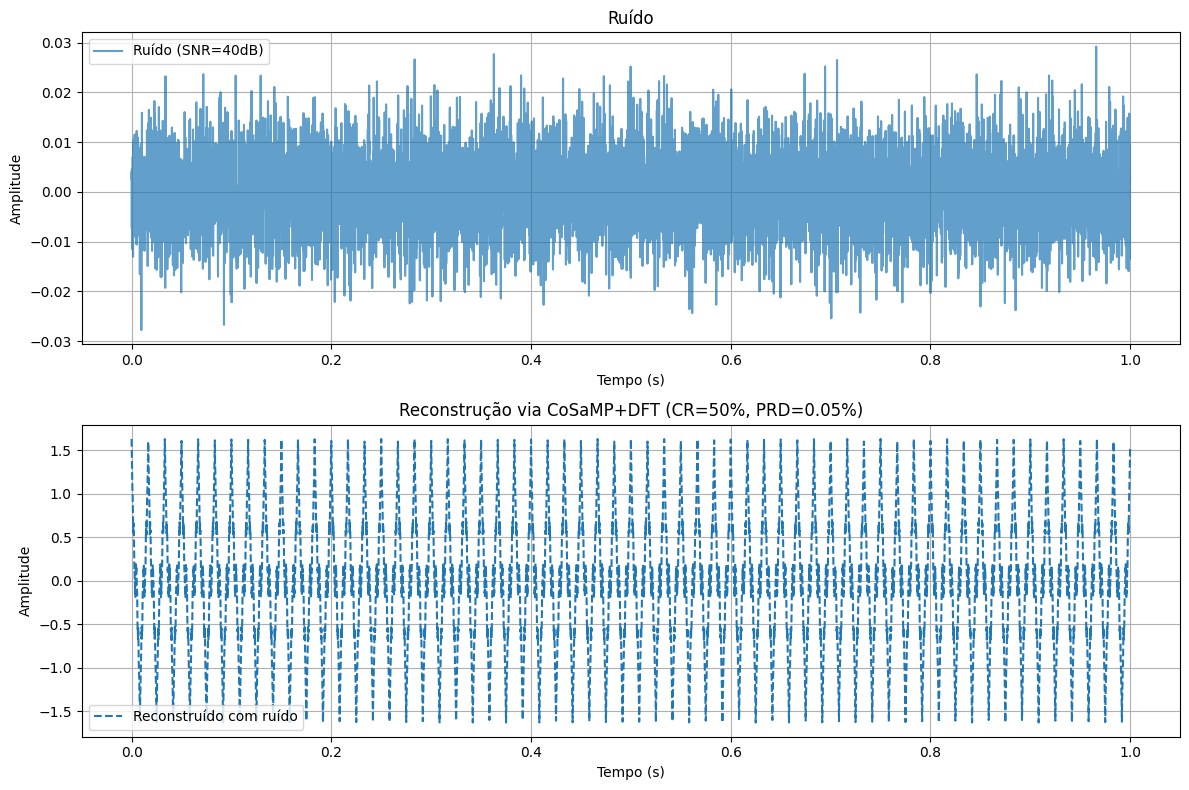

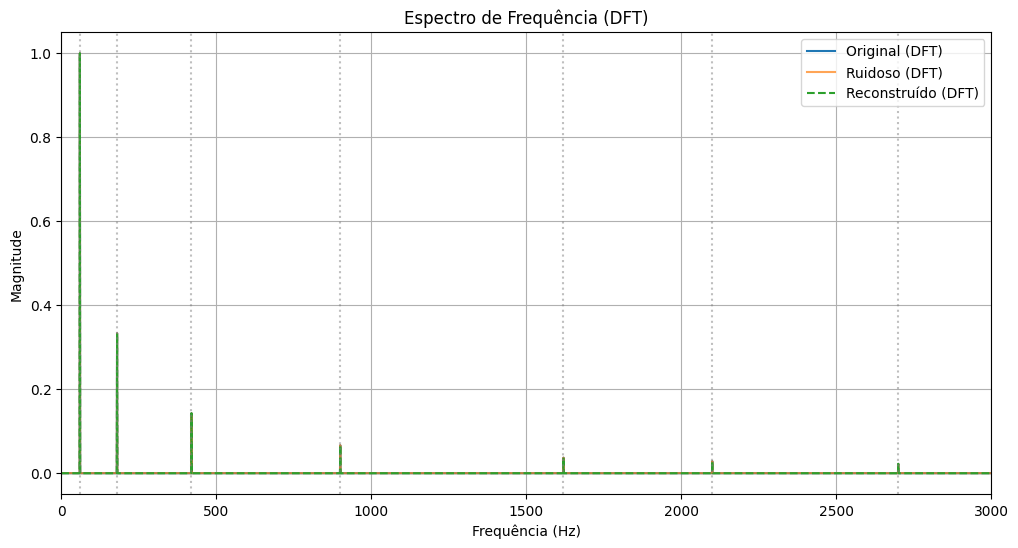

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

print("cosamp real, DFT ajustado")

# Funções de métrica
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Parâmetros do sinal
Fs = 8192
Ts = 1 / Fs
t = np.arange(Fs) * Ts
f = 60

harm = [1, 3, 7, 15, 27, 35, 45]
y = np.sum([(1/h) * np.cos(2 * np.pi * h * f * t) for h in harm], axis=0)

# DFT do sinal original
original_dft = np.abs(fft(y)) / len(y)

# Adição de ruído
SNR_dB = 40
ruido = np.random.normal(0, np.sqrt(np.var(y)/(10 ** (SNR_dB / 10))), len(y))
y_ruidoso = y + ruido

# Parâmetros de compressão
CR = 50
N = len(y)
M = int(N * (100 - CR) / 100)

# Matriz DFT explícita
def create_dft_matrix(N):
    n = np.arange(N)
    k = n.reshape((N, 1))
    W = np.exp(-2j * np.pi * k * n / N) / np.sqrt(N)
    return W

# Algoritmo CoSaMP verdadeiro
def cosamp(Phi, y, K, max_iter=10, tol=1e-5):
    residual = y.copy()
    idx = np.array([], dtype=int)
    x = np.zeros(Phi.shape[1], dtype=complex)

    for _ in range(max_iter):
        proxy = Phi.conj().T @ residual
        omega = np.argsort(np.abs(proxy))[-2*K:]
        idx = np.union1d(idx, omega).astype(int)
        Phi_selected = Phi[:, idx]
        b, _, _, _ = np.linalg.lstsq(Phi_selected, y, rcond=None)

        # Prune
        idx_new = np.argsort(np.abs(b))[-K:]
        idx = idx[idx_new]
        x_temp = np.zeros(Phi.shape[1], dtype=complex)
        x_temp[idx] = b[idx_new]
        residual = y - Phi @ x_temp

        if np.linalg.norm(residual) < tol:
            break
    return x_temp

# Execução do experimento
n_iterations = 5
prd_values = np.zeros(n_iterations)
prd_noisy_values = np.zeros(n_iterations)
rmse_values = np.zeros(n_iterations)
rmse_noisy_values = np.zeros(n_iterations)
harmonic_errors = np.zeros((n_iterations, len(harm)))

F = create_dft_matrix(N)  # matriz DFT completa

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")

    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    Phi = F[samples, :]

    clean_measurements = y[samples]
    noisy_measurements = y_ruidoso[samples]

    coeffs_clean = cosamp(Phi, clean_measurements, K=14)
    reconstructed_clean = ifft(coeffs_clean * np.sqrt(N)).real  # ifft normalizado

    coeffs_noisy = cosamp(Phi, noisy_measurements, K=14)
    reconstructed_noisy = ifft(coeffs_noisy * np.sqrt(N)).real

    # Normalização opcional para comparar forma de onda
    reconstructed_clean *= (np.max(y) / np.max(reconstructed_clean))
    reconstructed_noisy *= (np.max(y) / np.max(reconstructed_noisy))

    # Métricas
    prd_values[i] = calculate_prd(y, reconstructed_clean)
    prd_noisy_values[i] = calculate_prd(y, reconstructed_noisy)
    rmse_values[i] = calculate_rmse(y, reconstructed_clean)
    rmse_noisy_values[i] = calculate_rmse(y, reconstructed_noisy)

    # Erros nas harmônicas
    recon_dft = np.abs(fft(reconstructed_noisy))/len(reconstructed_noisy)
    for j in range(len(harm)):
        idx_h = int(harm[j] * f * N / Fs)
        harmonic_errors[i, j] = 100 * np.abs(np.abs(original_dft[idx_h]) - np.abs(recon_dft[idx_h])) / np.abs(original_dft[idx_h])

# Resultados
print("\nResultados para o sinal SEM ruído:")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")

print("\nResultados para o sinal COM ruído:")
print(f"PRD médio: {np.mean(prd_noisy_values):.2f}% ± {np.std(prd_noisy_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_noisy_values):.4f} ± {np.std(rmse_noisy_values):.4f}")

print("\nErros médios nas harmônicas (com ruído):")
for j, h in enumerate(harm):
    print(f"Harmônica {h}: {np.mean(harmonic_errors[:, j]):.4f} ± {np.std(harmonic_errors[:, j]):.4f}")

# Plot dos sinais
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, ruido, alpha=0.7, label=f'Ruído (SNR={SNR_dB}dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Ruído')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, reconstructed_noisy, '--', label='Reconstruído com ruído')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Reconstrução via CoSaMP+DFT (CR={CR}%, PRD={np.mean(prd_noisy_values):.2f}%)')
plt.grid()

plt.tight_layout()
plt.show()

# Plot do espectro DFT
freq = np.fft.fftfreq(N, Ts)[:N//2]
plt.figure(figsize=(12, 6))
plt.plot(freq, 2/N * np.abs(fft(y)[:N//2]), label='Original (DFT)')
plt.plot(freq, 2/N * np.abs(fft(y_ruidoso)[:N//2]), alpha=0.7, label='Ruidoso (DFT)')
plt.plot(freq, 2/N * np.abs(fft(reconstructed_noisy)[:N//2]), '--', label='Reconstruído (DFT)')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência (DFT)')
plt.legend()
plt.grid()
plt.show()


# **Algoritmo OMP com a dct**

Algoritmo OMP com DCT
Iteração 1/5
Iteração 2/5
Iteração 3/5
Iteração 4/5
Iteração 5/5

Resultados para o sinal SEM ruído na entrada:
PRD médio: 4.52% ± 0.23%
RMSE médio: 0.0341 ± 0.0018

Resultados para o sinal COM ruído (SNR = 40dB):
PRD médio: 3.97% ± 0.01%
RMSE médio: 0.0300 ± 0.0001

Erros médios nas harmônicas (com ruído):
Harmônica 1: -0.0248 ± 0.0549
Harmônica 3: 0.0662 ± 0.1286
Harmônica 7: 0.3586 ± 0.1073
Harmônica 15: 2.1396 ± 0.5597
Harmônica 27: 16.8142 ± 1.6474
Harmônica 35: 28.6149 ± 2.1247
Harmônica 45: 99.9849 ± 0.0178


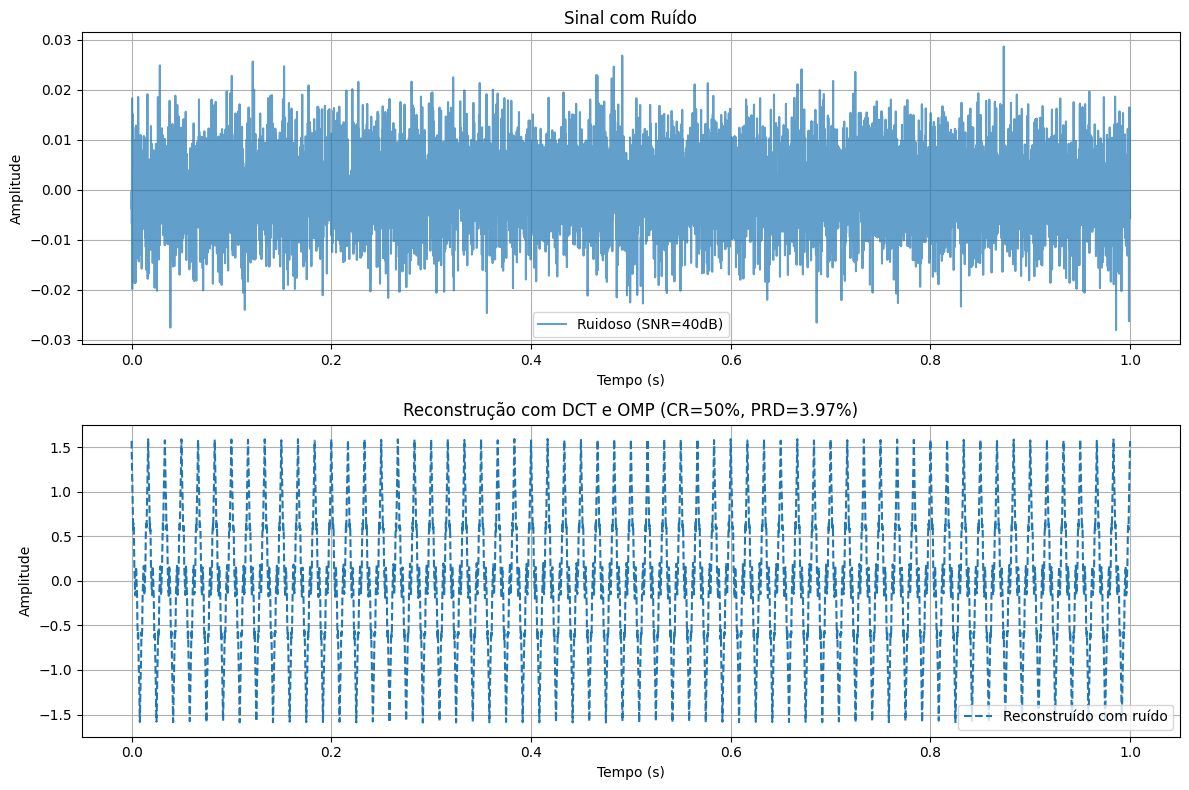

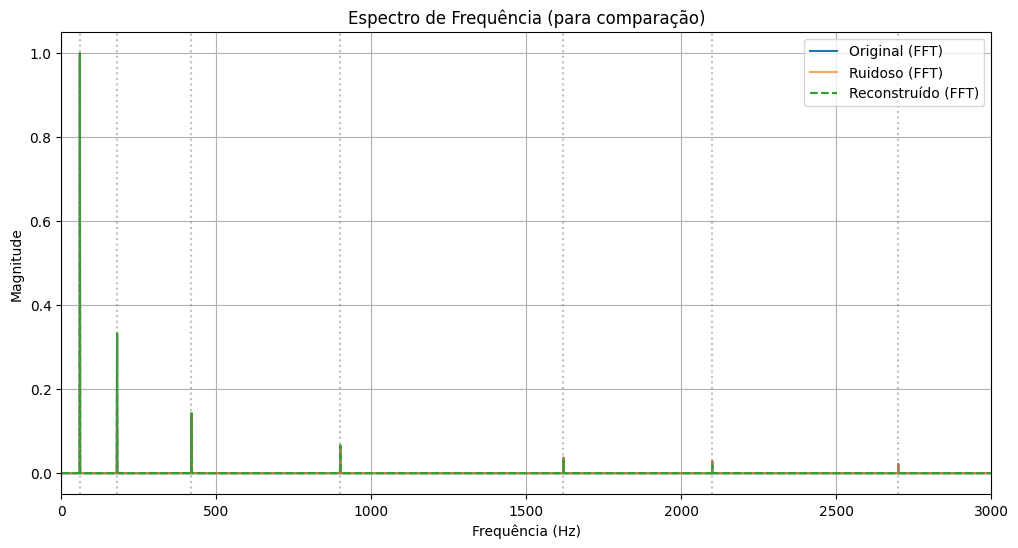

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

print("Algoritmo OMP com DCT")

# Funções de métrica (mantidas as mesmas)
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Parâmetros do sinal (mantidos os mesmos)
Fs = 8192       # Frequência de amostragem
Ts = 1 / Fs     # Período de amostragem
t = np.arange(Fs) * Ts  # Vetor de tempo
f = 60          # Frequência fundamental (Hz)

# Sinal harmônico com componentes ímpares
harm = [1, 3, 7, 15, 27, 35, 45]
y = np.sum([(1/h) * np.cos(2 * np.pi * h * f * t) for h in harm], axis=0)

# DCT do sinal original
original_dct = 2*np.abs(np.fft.fft(y, norm='ortho'))/len(y)

# Adição de ruído gaussiano
SNR_dB = 40  # Razão sinal-ruído em dB
ruido = np.random.normal(0, np.sqrt(np.var(y)/(10 ** (SNR_dB / 10))), len(y))
y_ruidoso = y + ruido

# Compressive Sensing
CR = 50  # Taxa de compressão (50%)
N = len(y)
M = int(N * (100 - CR) / 100)  # Número de medidas

# Algoritmo OMP (Orthogonal Matching Pursuit)
def omp(A, y, k):
    """
    Implementação do OMP para recuperação esparsa

    Parâmetros:
    A : Matriz de medição (M x N)
    y : Vetor de medidas (M x 1)
    k : Número esperado de coeficientes não nulos

    Retorna:
    x : Vetor esparso estimado (N x 1)
    """
    m, n = A.shape
    x = np.zeros(n)
    residual = y.copy()
    support = []

    for _ in range(k):
        # Passo 1: Encontrar o átomo mais correlacionado com o resíduo
        correlations = np.abs(A.T @ residual)
        correlations[support] = 0  # Ignorar átomos já selecionados
        new_idx = np.argmax(correlations)

        # Passo 2: Adicionar ao suporte
        support.append(new_idx)

        # Passo 3: Resolver mínimos quadrados com os átomos selecionados
        A_support = A[:, support]
        x_support = np.linalg.lstsq(A_support, y, rcond=None)[0]

        # Passo 4: Atualizar a solução e o resíduo
        x.fill(0)
        x[support] = x_support
        residual = y - A @ x

    return x

# Execução do experimento (5 iterações)
n_iterations = 5
prd_values = np.zeros(n_iterations)
prd_noisy_values = np.zeros(n_iterations)
rmse_values = np.zeros(n_iterations)
rmse_noisy_values = np.zeros(n_iterations)
harmonic_errors = np.zeros((n_iterations, len(harm)))

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")
    # Amostragem aleatória diferente a cada iteração
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    # Matriz de medição (DCT subamostrada)
    A = dct(np.eye(N), norm='ortho')[samples, :]

    # Medições com e sem ruído
    clean_measurements = y[samples]
    noisy_measurements = y_ruidoso[samples]

    # Reconstrução com OMP (k=14 coeficientes não nulos)
    # Reconstrução do sinal limpo (para comparação)
    coeffs_clean = omp(A, clean_measurements, k=14)
    reconstructed_clean = idct(coeffs_clean, norm='ortho')
    reconstructed_clean = reconstructed_clean * (np.max(y) / np.max(reconstructed_clean))

    # Reconstrução do sinal ruidoso
    coeffs_noisy = omp(A, noisy_measurements, k=14)
    reconstructed_noisy = idct(coeffs_noisy, norm='ortho')

    # Cálculo das métricas
    prd_values[i] = calculate_prd(y, reconstructed_clean)
    prd_noisy_values[i] = calculate_prd(y, reconstructed_noisy)  # Comparando com o original sem ruído
    rmse_values[i] = calculate_rmse(y, reconstructed_clean)
    rmse_noisy_values[i] = calculate_rmse(y, reconstructed_noisy)

    # Erros nas harmônicas (usando a reconstrução ruidosa)
    recon_dct = 2*np.abs(np.fft.fft(reconstructed_noisy, norm='ortho'))/len(reconstructed_noisy)
    for j in range(len(harm)):
        idx_h = (int(harm[j]) * f/(Fs/N))
        harmonic_errors[i, j] = 100*(np.abs(original_dct[(int(idx_h))]) - np.abs(recon_dct[(int(idx_h))]))/np.abs(original_dct[(int(idx_h))])

# Resultados finais
print("\nResultados para o sinal SEM ruído na entrada:")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")

print("\nResultados para o sinal COM ruído (SNR = 40dB):")
print(f"PRD médio: {np.mean(prd_noisy_values):.2f}% ± {np.std(prd_noisy_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_noisy_values):.4f} ± {np.std(rmse_noisy_values):.4f}")
print("\nErros médios nas harmônicas (com ruído):")
for j, h in enumerate(harm):
    print(f"Harmônica {h}: {np.mean(harmonic_errors[:, j]):.4f} ± {np.std(harmonic_errors[:, j]):.4f}")

# Plot dos sinais
plt.figure(figsize=(12, 8))

# Sinal original vs ruidoso
plt.subplot(2, 1, 1)
plt.plot(t, ruido, alpha=0.7, label=f'Ruidoso (SNR={SNR_dB}dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Sinal com Ruído')
plt.grid()

# Sinal original vs reconstruído com ruído
plt.subplot(2, 1, 2)
plt.plot(t, reconstructed_noisy, '--', label='Reconstruído com ruído')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Reconstrução com DCT e OMP (CR={CR}%, PRD={np.mean(prd_noisy_values):.2f}%)')
plt.grid()

plt.tight_layout()
plt.show()

# Plot do espectro DCT
freq = np.fft.fftfreq(N, Ts)[:N//2]
plt.figure(figsize=(12, 6))
plt.plot(freq, 2/N * np.abs(np.fft.fft(y)[0:N//2]), label='Original (FFT)')
plt.plot(freq, 2/N * np.abs(np.fft.fft(y_ruidoso)[0:N//2]), alpha=0.7, label='Ruidoso (FFT)')
plt.plot(freq, 2/N * np.abs(np.fft.fft(reconstructed_noisy)[0:N//2]), '--', label='Reconstruído (FFT)')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência (para comparação)')
plt.legend()
plt.grid()
plt.show()

#**Algoritmo OMP com a dft**

Algoritmo OMP com DFT
Iteração 1/5
Iteração 2/5
Iteração 3/5
Iteração 4/5
Iteração 5/5

Resultados para o sinal SEM ruído na entrada:
PRD médio: 0.00% ± 0.00%
RMSE médio: 0.0000 ± 0.0000

Resultados para o sinal COM ruído (SNR = 40dB):
PRD médio: 0.07% ± 0.01%
RMSE médio: 0.0005 ± 0.0001

Erros médios nas harmônicas (com ruído):
Harmônica 1: -0.0026 ± 0.0145
Harmônica 3: 0.0691 ± 0.0530
Harmônica 7: -0.0322 ± 0.0786
Harmônica 15: -0.2885 ± 0.1142
Harmônica 27: -0.2130 ± 0.2146
Harmônica 35: 0.2266 ± 0.6072
Harmônica 45: 0.4631 ± 0.6792


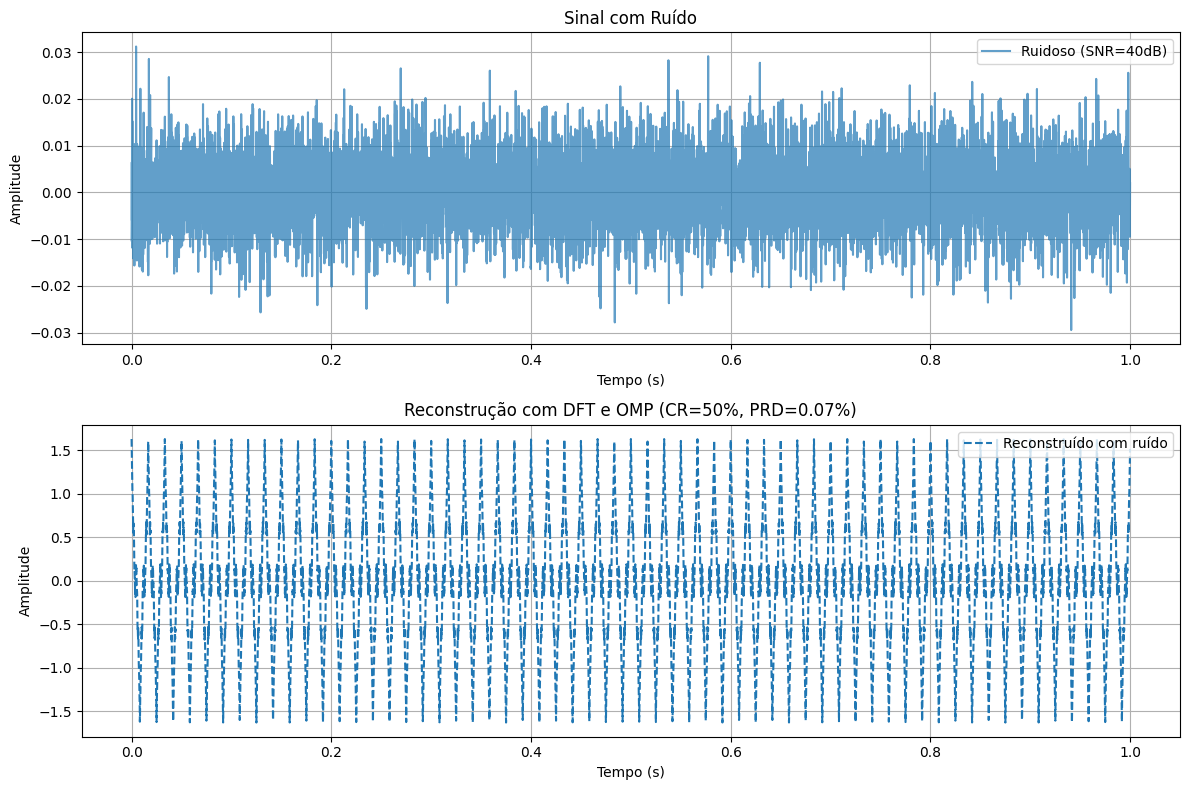

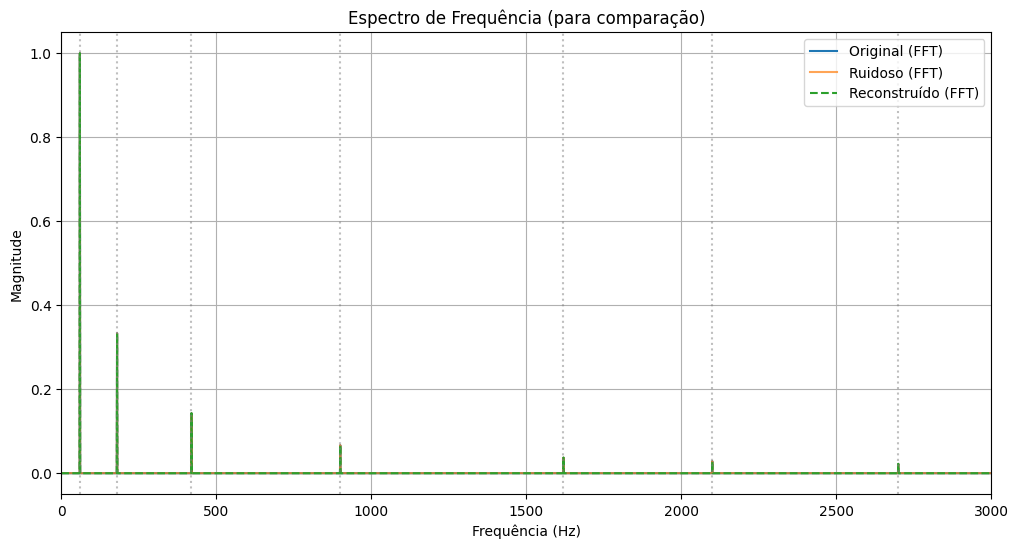

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print("Algoritmo OMP com DFT")

# Funções de métrica
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Parâmetros do sinal
Fs = 8192
Ts = 1 / Fs
t = np.arange(Fs) * Ts
f = 60

# Sinal harmônico com componentes ímpares
harm = [1, 3, 7, 15, 27, 35, 45]
y = np.sum([(1/h) * np.cos(2 * np.pi * h * f * t) for h in harm], axis=0)

# DFT do sinal original
original_dft = 2*np.abs(np.fft.fft(y))/len(y)

# Adição de ruído gaussiano
SNR_dB = 40
ruido = np.random.normal(0, np.sqrt(np.var(y)/(10 ** (SNR_dB / 10))), len(y))
y_ruidoso = y + ruido

# Compressive Sensing
CR = 50
N = len(y)
M = int(N * (100 - CR) / 100)

# OMP
def omp(A, y, k):
    m, n = A.shape
    x = np.zeros(n, dtype=complex)
    residual = y.copy()
    support = []

    for _ in range(k):
        correlations = np.abs(A.T.conj() @ residual)
        correlations[support] = 0
        new_idx = np.argmax(correlations)
        support.append(new_idx)

        A_support = A[:, support]
        x_support = np.linalg.lstsq(A_support, y, rcond=None)[0]

        x.fill(0)
        x[support] = x_support
        residual = y - A @ x

    return x

# Experimento
n_iterations = 5
prd_values = np.zeros(n_iterations)
prd_noisy_values = np.zeros(n_iterations)
rmse_values = np.zeros(n_iterations)
rmse_noisy_values = np.zeros(n_iterations)
harmonic_errors = np.zeros((n_iterations, len(harm)))

# Matriz base DFT (completa)
F = np.fft.fft(np.eye(N)) / np.sqrt(N)

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    A = F[samples, :]

    clean_measurements = y[samples]
    noisy_measurements = y_ruidoso[samples]

    coeffs_clean = omp(A, clean_measurements, k=14)
    reconstructed_clean = np.real(np.fft.ifft(coeffs_clean) * np.sqrt(N))
    reconstructed_clean *= np.max(y) / np.max(reconstructed_clean)

    coeffs_noisy = omp(A, noisy_measurements, k=14)
    reconstructed_noisy = np.real(np.fft.ifft(coeffs_noisy) * np.sqrt(N))

    prd_values[i] = calculate_prd(y, reconstructed_clean)
    prd_noisy_values[i] = calculate_prd(y, reconstructed_noisy)
    rmse_values[i] = calculate_rmse(y, reconstructed_clean)
    rmse_noisy_values[i] = calculate_rmse(y, reconstructed_noisy)

    recon_dft = 2*np.abs(np.fft.fft(reconstructed_noisy))/len(reconstructed_noisy)
    for j in range(len(harm)):
        idx_h = int(harm[j] * f / (Fs/N))
        harmonic_errors[i, j] = 100 * (np.abs(original_dft[idx_h]) - np.abs(recon_dft[idx_h])) / np.abs(original_dft[idx_h])

# Resultados
print("\nResultados para o sinal SEM ruído na entrada:")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")

print("\nResultados para o sinal COM ruído (SNR = 40dB):")
print(f"PRD médio: {np.mean(prd_noisy_values):.2f}% ± {np.std(prd_noisy_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_noisy_values):.4f} ± {np.std(rmse_noisy_values):.4f}")
print("\nErros médios nas harmônicas (com ruído):")
for j, h in enumerate(harm):
    print(f"Harmônica {h}: {np.mean(harmonic_errors[:, j]):.4f} ± {np.std(harmonic_errors[:, j]):.4f}")

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, ruido, alpha=0.7, label=f'Ruidoso (SNR={SNR_dB}dB)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Sinal com Ruído')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, reconstructed_noisy, '--', label='Reconstruído com ruído')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Reconstrução com DFT e OMP (CR={CR}%, PRD={np.mean(prd_noisy_values):.2f}%)')
plt.grid()

plt.tight_layout()
plt.show()

freq = np.fft.fftfreq(N, Ts)[:N//2]
plt.figure(figsize=(12, 6))
plt.plot(freq, 2/N * np.abs(np.fft.fft(y)[0:N//2]), label='Original (FFT)')
plt.plot(freq, 2/N * np.abs(np.fft.fft(y_ruidoso)[0:N//2]), alpha=0.7, label='Ruidoso (FFT)')
plt.plot(freq, 2/N * np.abs(np.fft.fft(reconstructed_noisy)[0:N//2]), '--', label='Reconstruído (FFT)')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência (para comparação)')
plt.legend()
plt.grid()
plt.show()


Iteração 1/5
Iteração 2/5
Iteração 3/5
Iteração 4/5
Iteração 5/5

=== Resultados ===
PRD médio: 0.69% ± 0.01%

Erros médios nas harmônicas:
Harmônica 1: 0.02% ± 0.01%
Harmônica 3: 0.04% ± 0.03%
Harmônica 7: 0.06% ± 0.05%
Harmônica 15: 0.14% ± 0.12%
Harmônica 27: 1.02% ± 0.10%
Harmônica 35: 0.62% ± 0.35%
Harmônica 45: 0.27% ± 0.14%


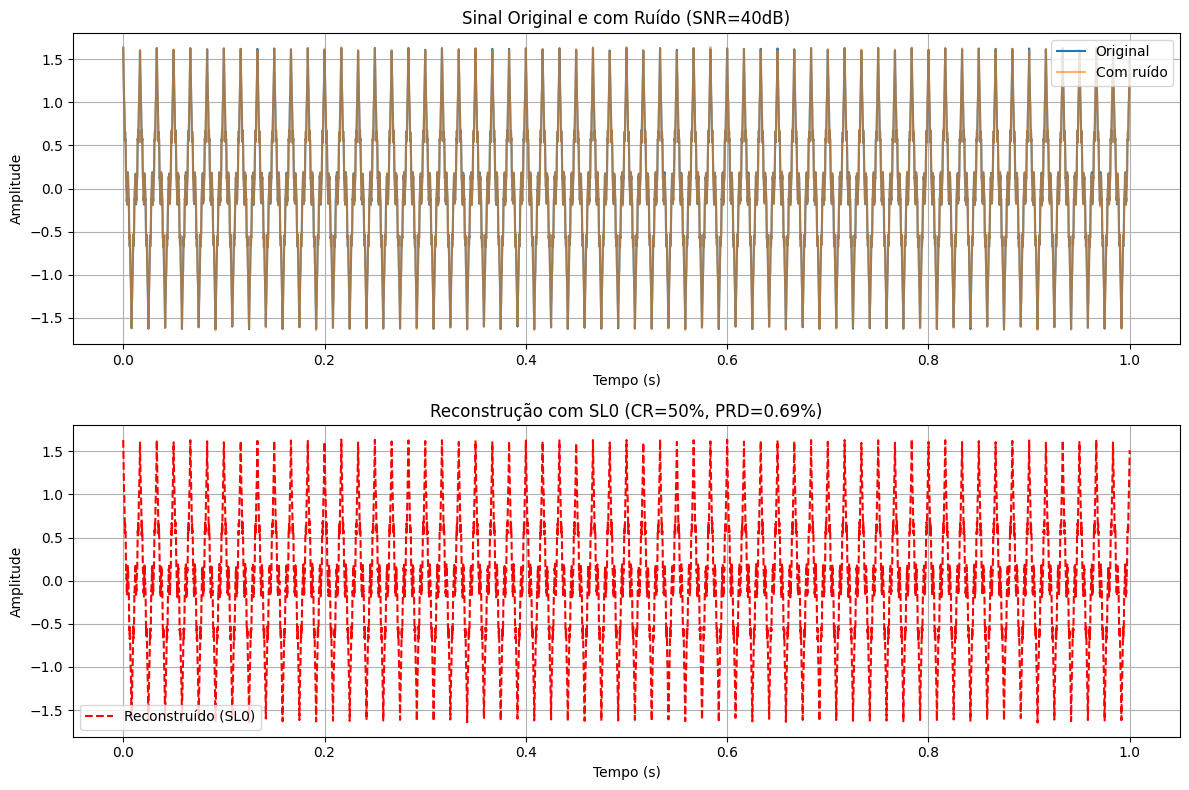

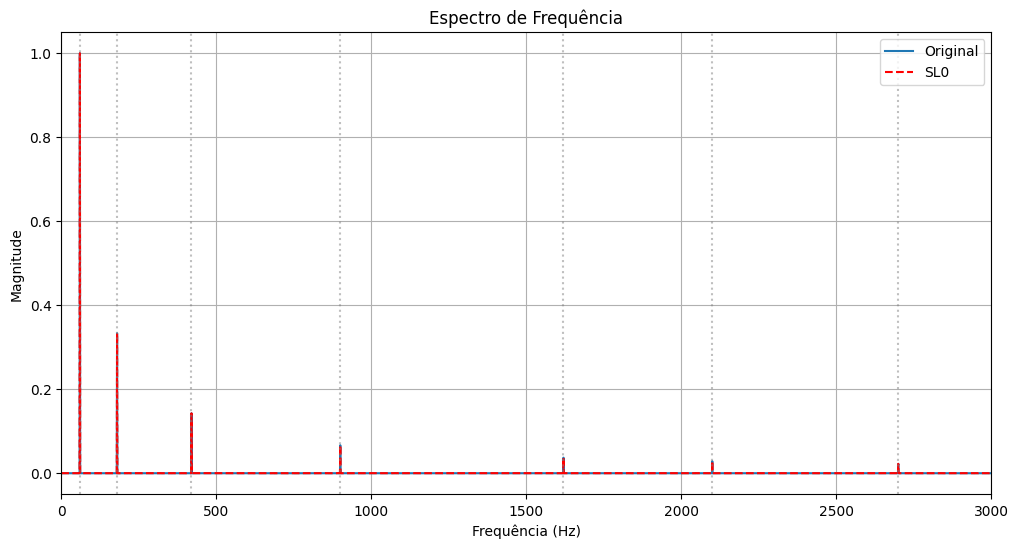

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp

# Funções de métrica (mantidas iguais)
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Implementação do SL0 (adaptada)
def sl0(A, y_compressed, sigma_min=0.1, sigma_decrease_factor=0.5, mu_0=2, L=1):
    """
    SL0 adaptado para seu sinal harmônico
    """
    A_pinv = np.linalg.pinv(A)
    s = A_pinv @ y_compressed
    sigma = 2.0 * np.abs(s).max()

    while sigma > sigma_min:
        for _ in range(L):
            delta = s * np.exp(-np.abs(s)**2 / sigma**2)
            s = s - mu_0 * delta
            s = s - A_pinv @ (A @ s - y_compressed)
        sigma *= sigma_decrease_factor

    return s

# --- Parâmetros do sinal (seus parâmetros originais) ---
Fs = 8192
Ts = 1 / Fs
t = np.arange(Fs) * Ts
f = 60  # Frequência fundamental
harm = [1, 3, 7, 15, 27, 35, 45]  # Componentes harmônicas ímpares

# Geração do sinal original
y = np.sum([(1/h) * np.cos(2 * np.pi * h * f * t) for h in harm], axis=0)
original_dft = 2*np.abs(np.fft.fft(y))/len(y)

# Adição de ruído (SNR = 40dB)
SNR_dB = 40
ruido = np.random.normal(0, np.sqrt(np.var(y)/(10 ** (SNR_dB / 10))), len(y))
y_ruidoso = y + ruido

# --- Compressive Sensing ---
CR = 50  # Taxa de compressão (50%)
N = len(y)
M = int(N * (100 - CR) / 100)

# Matriz base DFT (normalizada)
F = np.fft.fft(np.eye(N)) / np.sqrt(N)

# --- Experimento Principal ---
n_iterations = 5
prd_values = np.zeros(n_iterations)
harmonic_errors = np.zeros((n_iterations, len(harm)))

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")

    # Seleciona amostras aleatórias
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    # Cria matriz de medição
    A = F[samples, :]
    noisy_measurements = y_ruidoso[samples]

    # Executa SL0 adaptado
    coeffs_sl0 = sl0(A, noisy_measurements)

    # Reconstrução do sinal
    reconstructed = np.real(np.fft.ifft(coeffs_sl0) * np.sqrt(N))

    # Cálculo das métricas
    prd_values[i] = calculate_prd(y, reconstructed)

    # Análise espectral
    recon_dft = 2*np.abs(np.fft.fft(reconstructed))/len(reconstructed)
    for j, h in enumerate(harm):
        idx_h = int(h * f / (Fs/N))
        harmonic_errors[i,j] = 100*np.abs(original_dft[idx_h]-recon_dft[idx_h])/original_dft[idx_h]

# --- Resultados ---
print("\n=== Resultados ===")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print("\nErros médios nas harmônicas:")
for j, h in enumerate(harm):
    print(f"Harmônica {h}: {np.mean(harmonic_errors[:,j]):.2f}% ± {np.std(harmonic_errors[:,j]):.2f}%")

# --- Visualização ---
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(t, y, label='Original')
plt.plot(t, y_ruidoso, alpha=0.6, label='Com ruído')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Sinal Original e com Ruído (SNR=40dB)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(t, reconstructed, 'r--', label='Reconstruído (SL0)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Reconstrução com SL0 (CR={CR}%, PRD={np.mean(prd_values):.2f}%)')
plt.grid()
plt.tight_layout()

# Espectro de frequência
freq = np.fft.fftfreq(N, Ts)[:N//2]
plt.figure(figsize=(12,6))
plt.plot(freq, original_dft[:N//2], label='Original')
plt.plot(freq, recon_dft[:N//2], 'r--', label='SL0')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp

# Funções de métrica
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Implementação do SL0 (adaptada)
def sl0(A, y_compressed, sigma_min=0.1, sigma_decrease_factor=0.5, mu_0=2, L=1):
    """
    SL0 adaptado para seu sinal harmônico
    """
    A_pinv = np.linalg.pinv(A)
    s = A_pinv @ y_compressed
    sigma = 2.0 * np.abs(s).max()

    while sigma > sigma_min:
        for _ in range(L):
            delta = s * np.exp(-np.abs(s)**2 / sigma**2)
            s = s - mu_0 * delta
            s = s - A_pinv @ (A @ s - y_compressed)
        sigma *= sigma_decrease_factor

    return s

# --- Parâmetros do sinal ---
Fs = 8192
Ts = 1 / Fs
t = np.arange(Fs) * Ts
f = 60  # Frequência fundamental
harm = [1, 3, 7, 15, 27, 35, 45]  # Componentes harmônicas ímpares

# Geração do sinal original
y = np.sum([(1/h) * np.cos(2 * np.pi * h * f * t) for h in harm], axis=0)
original_dft = 2*np.abs(np.fft.fft(y))/len(y)

# Adição de ruído (SNR = 40dB)
SNR_dB = 40
ruido = np.random.normal(0, np.sqrt(np.var(y)/(10 ** (SNR_dB / 10))), len(y))
y_ruidoso = y + ruido

# --- Compressive Sensing ---
CR = 50  # Taxa de compressão (50%)
N = len(y)
M = int(N * (100 - CR) / 100)

# Matriz base DFT (normalizada)
F = np.fft.fft(np.eye(N)) / np.sqrt(N)

# --- Experimento Principal ---
n_iterations = 5
prd_values = np.zeros(n_iterations)
rmse_values = np.zeros(n_iterations)
prd_noisy_values = np.zeros(n_iterations)
rmse_noisy_values = np.zeros(n_iterations)
harmonic_errors = np.zeros((n_iterations, len(harm)))

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")

    # Seleciona amostras aleatórias
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    # Cria matriz de medição
    A = F[samples, :]
    clean_measurements = y[samples]
    noisy_measurements = y_ruidoso[samples]

    # Executa SL0 para medições limpas
    coeffs_clean = sl0(A, clean_measurements)
    reconstructed_clean = np.real(np.fft.ifft(coeffs_clean) * np.sqrt(N))
    reconstructed_clean *= np.max(y) / np.max(reconstructed_clean)  # Normalização

    # Executa SL0 para medições ruidosas
    coeffs_noisy = sl0(A, noisy_measurements)
    reconstructed_noisy = np.real(np.fft.ifft(coeffs_noisy) * np.sqrt(N))

    # Cálculo das métricas
    prd_values[i] = calculate_prd(y, reconstructed_clean)
    rmse_values[i] = calculate_rmse(y, reconstructed_clean)
    prd_noisy_values[i] = calculate_prd(y, reconstructed_noisy)
    rmse_noisy_values[i] = calculate_rmse(y, reconstructed_noisy)

    # Análise espectral
    recon_dft = 2*np.abs(np.fft.fft(reconstructed_noisy))/len(reconstructed_noisy)
    for j, h in enumerate(harm):
        idx_h = int(h * f / (Fs/N))
        harmonic_errors[i,j] = 100*np.abs(original_dft[idx_h]-recon_dft[idx_h])/original_dft[idx_h]

# --- Resultados ---
print("\n=== Resultados ===")
print("Resultados para o sinal SEM ruído na entrada:")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")
print("\nResultados para o sinal COM ruído (SNR = 40dB):")
print(f"PRD médio: {np.mean(prd_noisy_values):.2f}% ± {np.std(prd_noisy_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_noisy_values):.4f} ± {np.std(rmse_noisy_values):.4f}")
print("\nErros médios nas harmônicas (com ruído):")
for j, h in enumerate(harm):
    print(f"Harmônica {h}: {np.mean(harmonic_errors[:,j]):.2f}% ± {np.std(harmonic_errors[:,j]):.2f}%")

# --- Visualização ---
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(t, y, label='Original')
plt.plot(t, y_ruidoso, alpha=0.6, label='Com ruído')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Sinal Original e com Ruído (SNR=40dB)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(t, reconstructed_noisy, 'r--', label='Reconstruído (SL0)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Reconstrução com SL0 (CR={CR}%, PRD={np.mean(prd_noisy_values):.2f}%)')
plt.grid()
plt.tight_layout()

# Espectro de frequência
freq = np.fft.fftfreq(N, Ts)[:N//2]
plt.figure(figsize=(12,6))
plt.plot(freq, original_dft[:N//2], label='Original')
plt.plot(freq, recon_dft[:N//2], 'r--', label='SL0')
for h in harm:
    plt.axvline(h*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência')
plt.legend()
plt.grid()
plt.show()